In [1]:
%matplotlib inline

import torch
from IPython import display  # 这个函数的作用？
import matplotlib.pyplot as plt
import numpy as np
import random

生成数据，并引入N(0,0.0001)的随机噪声

In [2]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, num_inputs, dtype=torch.float32)

labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# 此处的另外一种写法，按照矩阵乘法的方式，不过似乎并没有原写法简洁
# labels = torch.mm(features, torch.Tensor(true_w).view(2, 1)).view(1000) + true_b

# 引入噪声
labels += torch.normal(0, 0.01, size=labels.size())

绘制散点图，观察我们生成的数据

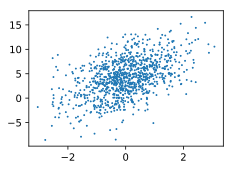

In [3]:
def use_svg_display():
    display.set_matplotlib_formats('svg')
    

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    

set_figsize()
# 原文中为 plt.scatter(features[:, 0].numpy(), labels.numpy(), s=1)，
# 就运行情况来看，似乎无需将Tensor转换为np.Array制图？
plt.scatter(features[:, 0], labels, s=1)  # s为marker size，也就是点的大小

按batch读取数据

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    
    for i in range(0, num_examples, batch_size):
        # LongTensor（CPU下表示方式）指定数据类型为long(64位有符号整数)，效果等同于torch.Tensor(..., dtype=long)
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        
        # yield返回一个生成器generator，本质是iterable，即可迭代对象，用于循环中
        # torch.index_select(input, dim, index, out=None) → Tensor
        # 此处使用的是Tensor.index_select()版本，除了input以外和上方法相同，作用是按索引（index, LongTensor）取subset
        yield features.index_select(0, j), labels.index_select(0, j)

尝试读取第一个小批量数据样本

In [5]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-1.1295, -0.4325],
        [-2.5561, -0.8023],
        [-1.6603, -0.7129],
        [ 1.3449,  0.8374],
        [ 0.1930, -0.4010],
        [ 0.7215,  0.3362],
        [-0.8553,  1.2587],
        [-0.4483, -1.2598],
        [-0.9755, -0.6129],
        [-0.7691, -0.9349]]) tensor([ 3.4020,  1.8371,  3.3123,  4.0298,  5.9559,  4.5014, -1.7880,  7.5824,
         4.3384,  5.8460])


初始化模型参数

In [6]:
w = torch.normal(0, 0.01, size=(num_inputs, 1), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

由于需要对w以及b求梯度，需要设置requires_grad=True

In [7]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

定义模型

In [8]:
def linreg(X, w, b):
    return torch.mm(X, w) + b  # torch.mm()为矩阵乘法，不允许广播机制

定义损失函数

In [9]:
def squared_loss(y_hat, y):
    # 此处为什么要修改y的形式？以及为什么原文提到这个返回的是向量？
    # 提到是向量的原因：返回的是每一条数据的Loss组成的向量，整体loss的话需要进行sum()操作
    # y_hat为矩阵运算结果：torch.Size([1000, 1])
    # y为我们生成的labels：torch.Size([1000])
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

定义优化算法，这里使用mini-batch SGD

In [10]:
def sgd(params, lr, batch_size):
    for param in params:
        # 如果我们想要修改tensor的数值，但是又不希望被autograd记录（即不会影响反向传播），那么我么可以对tensor.data进行操作。
        # 没有加.data的时候，产生报错：
        # RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.
        # 大概意思是，不能对有梯度的叶节点（w和b）直接进行in-place替换操作
        param.data -= lr * param.grad / batch_size  # 这个地方使用的是param.data

训练模型

In [11]:
lr = 0.03
num_epochs = 3
# 重命名上述的函数
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()
        # 小批量的模型损失对模型参数求梯度
        l.backward()
        # 更新参数值
        sgd([w, b], lr, batch_size)
        
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    
    train_l = loss(net(features, w, b), labels)
    # train_l是向量，直接print意义不大，可求mean()或者sum()
    print("epoch %d, loss %f" % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.039070
epoch 2, loss 0.000143
epoch 3, loss 0.000049


查看我们最终的训练结果

In [12]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9990],
        [-3.3991]], requires_grad=True)
4.2 
 tensor([4.1996], requires_grad=True)
